## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
# findspark.init()
findspark.init('/home/j/spark-2.1.0-bin-hadoop2.7/spark-2.1.0-bin-hadoop2.7')

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
# file_index='BBBSBBBB'
file_index='SSSBSSSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
# filename=data_dir+'/decon_'+str(file_index)+'_'+str(meas)
print str(filename)
df=sqlContext.read.parquet(str(filename))
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
drwxrwxr-x 2 j j 45056 Apr 29 15:01 ../../Data/Weather/decon_BBBSBBBB.parquet
drwxrwxr-x 2 j j 45056 Apr 29 15:01 ../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
drwxrwxr-x 2 j j 45056 Apr 29 15:01 ../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
drwxrwxr-x 2 j j 45056 May 13 15:58 ../../Data/Weather/decon_SSSBSSSB_PRCP.parquet
drwxrwxr-x 2 j j  4096 May 13 15:59 ../../Data/Weather/decon_SSSBSSSB_SNWD.parquet
drwxrwxr-x 2 j j  4096 Apr 29 15:01 ../../Data/Weather/US_Weather_BBBSBBBB.parquet
drwxrwxr-x 2 j j  4096 May 13 09:49 ../../Data/Weather/US_Weather_SSSBSSSB.parquet
../../Data/Weather/decon_SSSBSSSB_SNWD.parquet
18
+-------------------+-----------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|          coeff_2|            coeff_3|el

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+--------------------+
|    station|latitude|longitude|elevation|             coeff_1|
+-----------+--------+---------+---------+--------------------+
|USC00047661| 37.8333|   -122.1|    189.0| -0.1296650213757599|
|USC00043652| 37.8667|-122.2167|    534.0| -0.1296650213757599|
|USC00045915| 37.8792|-121.9303|    661.4|-0.22142474683145594|
|USC00045915| 37.8792|-121.9303|    661.4| -0.1273819708704852|
+-----------+--------+---------+---------+--------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
# pdf.head(2)
pdf

station  latitude  longitude  elevation  count(station)  avg(coeff_1)
4  USC00040693   37.8744  -122.2606       94.5               1     -0.077562
6  USC00043652   37.8667  -122.2167      534.0               2     -0.099228
5  USC00045915   37.8792  -121.9303      661.4              10     -0.147397
0  USC00046305   37.8667  -120.8667       67.1               1    126.933190
1  USC00047661   37.8333  -122.1000      189.0               2     -0.099228
3  USC00049418   38.2000  -120.9667      100.9               1     -0.068804
2  USW00023258   37.6242  -120.9506       22.3               1     -0.068772

In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [9]:
# min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
min_lat,max_lat,min_long,max_long = (pdf.latitude.min(), pdf.latitude.max(), pdf.longitude.min(), pdf.longitude.max())
min_lat,max_lat,min_long,max_long
# middle 37.9121, -121.56364995

(37.624200000000002, 38.200000000000003, -122.2606, -120.86669999999999)

In [10]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

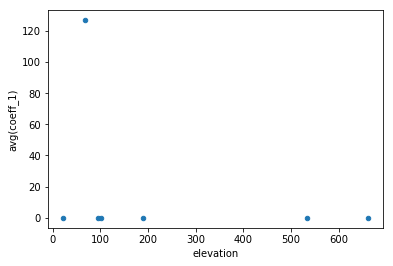

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');